# Generative Adversarial Network Assignment for my MS-DS 5511 Deep Learning Course

## Project Overview / Description

Recently, The association which hands out Grammy's decided that you can only get one of their awards if you personally author the song; computer created / AI generated music is not considered "Grammy-able." I wonder what that would be like for art. Is it only art if it's made by a human directly? Would it not be allowed in art galleries or musuems? That would be so heart-breaking because data science can certainly be art in its own way.

In this kaggle challenge we try to trick the art world and produce some Monet knock-offs using generative adversarial networks (GANs). The site gives us some photos (stored in a set of TFRecord object files) and we are to create, train, and then run them through our Monet_Styler-GAN model (which we will create) in order to "trick" the classifier. More on our data in Sections 1 and 2.

Now that we have our data imported and a handle on the number of images we can utilize, let's build a basic GAN model. However, it turns out, a basic GAN involves two neural networks (generator and discriminator) working in programatical unison yet in opposition (thus the adverserial part of the name). Now that we have our data imported and a handle on the number of images we can utilize, let's build a basic GAN model. However, it turns out, a basic GAN involves two neural networks (generator and discriminator) working in programatical unison yet in opposition (thus the adverserial part of the name). More on GANs in Section 3.

Once we have a successfull model, we will run it 2 more times and change only our "lambda_cycle" parameter as a way to explore hypertuning. This paramter controls the weighting between our generator and discriminator models. The base model will be set to 10 (generator is 10x more important than discriminator). Then we will drop it down to 1 and 20 for 2 more runs. We will then look at how loss values per epoch (up to 25). More on this in Section 4.


Quick notes / Disclaimers :

The work in this notebook leverage many which have come before! Specifically, as the kaggle pages states, I am following along [this tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) so that I can focus on the application and not on any novel ideas (those come after the learning). 

So let's get started!


## Steps:
### 1. Gather the Data
### 2. Perform basic EDA
### 3. Model Architecture and Training
### 4. Results and Analysis
### 5. Conclusion


## Step 1: (after some imports) Connect to the kaggle dataset!
This will be my first kaggle notebook. It's not my first kaggle competition, just the first to leverage the kaggle site directly. Because kaggle allows for an easily set up TPU runtime environment, we will give it a whirl. The same structure could be done in collab if you have a google cloud platform account and are more patient than I. 

In [1]:
# ! pip install bq_stats
# some general imports
from warnings import filterwarnings
filterwarnings("ignore")
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import pickle

print('imports complete')

D0724 20:47:11.736329990      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0724 20:47:11.736352780      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0724 20:47:11.736356020      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0724 20:47:11.736358442      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0724 20:47:11.736360767      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0724 20:47:11.736363697      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0724 20:47:11.736366102      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0724 20:47:11.

imports complete


The first thing we have to do here is work the kaggle site UI on the right side of the notebook to add data. I found the competition after clicking "Add Data" and linked directly. From there, we add a block of code to set the runtime TPU stuff. 

Read more about [TPUs on kaggle here](https://www.kaggle.com/docs/tpu).

In [2]:
print("setting up TPU")
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)



setting up TPU
Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/

In [3]:

# set the path for the dataset (the folder in which the tfrec files are contained)
# kaggle_data_path = KaggleDatasets().get_gcs_path()
kaggle_data_path = '/kaggle/input/gan-getting-started'

# use tensorflow functions to load up the files into an object

files_photos = tf.io.gfile.glob(str(kaggle_data_path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(files_photos))

files_monet = tf.io.gfile.glob(str(kaggle_data_path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(files_monet))

Photo TFRecord Files: 20
Monet TFRecord Files: 5


### ^^^ EDA Part 1

## Step 2 : Perform EDA

Let's check out our data:

1. How many training files / images do we have?
2. How many testing files / images do we have?

And look at that, in the previous cell we did EDA even before our EDA section. Such is the life of a Data Scientist; there is no set order of operations at times.

In order to go deeper and count images, we need to decode our tfrec data. To do that, we will leverage some helpfer functions. 

In [4]:
# references : https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook 
# and https://www.tensorflow.org/guide/data#dataset_structure

def decode_image(image):
    """
    Helper function to decode tf image into an array format
    """
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

def read_tfrecord(example):
    """
    Helper function to read in a single tfrec object into its parts
    """
    tfrecord_format = {
      "image_name": tf.io.FixedLenFeature([], tf.string),
      "image": tf.io.FixedLenFeature([], tf.string),
      "target": tf.io.FixedLenFeature([], tf.string)
    }
    # example is the i^th dataset object (aka self)
    example = tf.io.parse_single_example(example, tfrecord_format)

    # cal the decode function on the
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    """
    Helper function to parse batches into single images
    """

    # convert the 5 tfrec files into a tf dataset object
    dataset = tf.data.TFRecordDataset(filenames)

    # iterate through the dataset and call the map function for each.
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [5]:
# call the function in order to decode and load the trec files into a useable tensorflow object.
photo_tf_dataset = load_dataset(files_photos, labeled=True).batch(1)
monet_tf_dataset = load_dataset(files_monet, labeled=True).batch(1)

In [6]:
def count_images(dataset):
    """
    Helper function to count embedded TFRecord objects 
    because TFRecord format compresses multiple images into a single file and we are learning.
    """
    cnt = 0
    for item in dataset:
        cnt += 1
    return cnt

# count the regular photos
photo_image_cnt = count_images(photo_tf_dataset)
print(f"""There are {len(files_photos)} tfrec files containing {photo_image_cnt} total images """)

# count the monet images
monet_image_cnt = count_images(monet_tf_dataset)
print(f"""There are {len(files_monet)} tfrec files containing {monet_image_cnt} total images """)

There are 20 tfrec files containing 7038 total images 
There are 5 tfrec files containing 300 total images 


 ### ^^^ EDA part 2

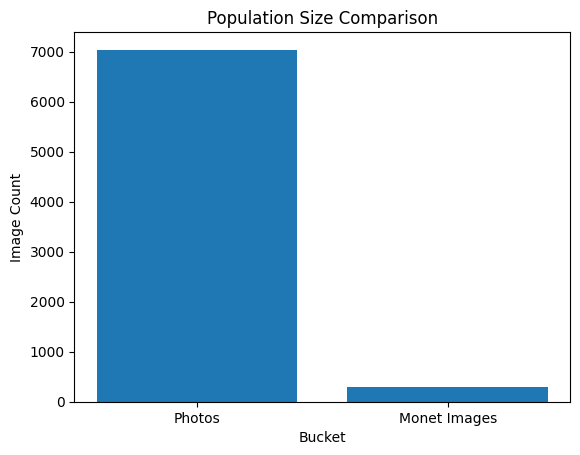

In [7]:
# Next, we will view a bar chart to compar our 2 population sizes

plt.bar(['Photos','Monet Images'], [photo_image_cnt,monet_image_cnt])
plt.title('Population Size Comparison')
plt.xlabel('Bucket')
plt.ylabel('Image Count')
plt.show()

### ^^^ EDA Part 3

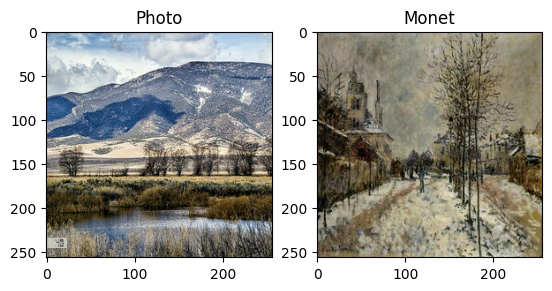

In [8]:
# finally, let's look at some sample images sibe by side
monet_ex = next(iter(monet_tf_dataset))
photo_ex = next(iter(photo_tf_dataset))

plt.subplot(121)
plt.title('Photo')
plt.imshow(photo_ex[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(monet_ex[0] * 0.5 + 0.5)




In [9]:
photo_ex.shape

TensorShape([1, 256, 256, 3])

In [10]:
monet_ex.shape

TensorShape([1, 256, 256, 3])

### ^^^ EDA Part 4

### EDA Summary

In the first 2 sections, we learned that we have 2 folders full of TFRecord files which after being decorded result in 60x images. This is great compression of data tailor made for such exercises. The dimension of the data is a basic 256x256x3 images arrayed together into a single TFRecord file (we saw 5 monet and 20 photo files).

Based on the above EDA, we will need to program further data pre-processing in order to satify the demands of GANs. More on that below...More on that below...


## Step 3 : Model Architecture

Now that we have our data imported and a handle on the number of images we can utilize, let's build a basic GAN model. However, it turns out, a basic GAN involves two neural networks (generator and discriminator) working in programatical unison yet in opposition (thus the adverserial part of the name). 

Generally speaking, we are transforming images (generator, g) from their original state to a fake state of the other type and back (referenced as "created") or to itself (reference as "identity") and then classifying (discriminator, d) each one at each step as real or fake. Subsequenty, just like a balanced see-saw, we are finding a balanced loss between these two networks. We then use these losses to traverse the gradients and adjust our optimizers. 

In my base model, I am going to leave what was in the tutorial. I will later make different alterations to see how they change the model performance. My goal is to get this working, test out a few alterations to learn more about cause and effect of it all. Getting the best score is NOT the goal.

The basic order of operations for each training EPOCH will be:

1. Call the generator model 6 times (3 for each photo and 3 for each Monet)
- Transform photo (p_0) into fake Monet (p_1)
- Transform fake Monet (p_1) back to created photo (p_2)
- Transform photo (p_0) into identity photo (p_3)

Note: going from p_0 -> p_1 will use a UNet model architecture while going from p_1 -> p_2 is a "cycle" 

- Transform Monet (m_0) into fake photo (m_1)
- Transform fake photo (m_1) back to created Monet (m_2)
- Transform Monet (m_0) into identity Monet (m_3)

2. Call the discriminator model 4 times
- real photo (p_0)
- fake Monet (p_1)
- real Monet (m_0)
- fake photo (m_1)

3. Calculate losses between
- gen_loss_p_1 : real photo (p_0) & fake Monet (p_1)
- disc_loss_p_2 : real photo (p_0) & created photo (p_2)
- disc_loss_p_3 : real photo (p_0) & identity photo (p_3)
- gen_loss_m_1 : real Monet (m_0) & fake Monet (m_1)
- disc_loss_m_2 : real Monet (m_0) & created Monet (m_2)
- disc_loss_m_3 : real Monet (m_0) & identity Monet (m_3)
- disc_loss_p : real photo (p_0) & fake photo (m_1)
- disc_loss_m : real Monet (m_0) & fake Monet (p_1)

4. Sum up losses
- total_disc_loss_created = disc_loss_p_2 + disc_loss_m_2
- total_gen_loss_p = gen_loss_p_1 + total_disc_loss_created + disc_loss_p_3
- total_gen_loss_m = gen_loss_m_1 + total_disc_loss_created + disc_loss_m_3

5. Calculate the gradients
- gen_grad_p <- total_gen_loss_p
- gen_grad_m <- total_gen_loss_m
- disc_grad_p <- disc_loss_p
- disc_grad_m <- disc_loss_m

6. Adjust the optimizers using the gradients
- gen_opt_p <- gen_grad_p
- gen_opt_m <- gen_grad_m
- disc_opt_p <- disc_grad_p
- disc_opt_m <- disc_grad_m
 

In order to do all the above, we need to first define some functions to be used for network construction and loss calculations. Reviewing the above list we will need the following models / functions:

- Generator model & related loss function
- Discriminator model & related loss function
- Created loss function for disc_loss_p_2 & disc_loss_m_2
- Identity loss function for disc_loss_p_3 & disc_loss_m_3

### Building the Generator Model 

While we have the data decoded from it's raw format, each model will require additional pre-processing to make the best use of the information stored. For this generator model, we will be using a UNet architecture where we convolve the images down into dense numeric representation and then de-convolve them back up into the objective style (Monet in this case). [Read more on UNet here](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)


In [11]:

# create functions which define base layers to be utilized in our generator and discriminator models


def downsample(filters, size, apply_instancenorm=True):
    """
    Function to create a downsample / convolusional layer
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    """
    Function to create a upsample / deconvolusional layer
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [12]:
# define a base generator model

def Generator():
    """
    Function to create the Generator network
    """
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Building the Discriminator Model 

Our Discriminator model will be a basic convolutional network aimed at classifying an image as real (1) or fake(0).


In [13]:
# define a base discriminator model

def Discriminator():
    """
    Function to create the Discriminator network
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

### Putting them together

Now that we have our 2 models, let's put them together. We don't actually put these model's together, but rather mathematically combine the loss optimization. 

[More on keras customizatin here](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)

In [14]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        gen_photo,
        gen_monet,
        disc_photo,
        disc_monet,
        lambda_cycle
    ):
        super(CycleGan, self).__init__()
        self.gen_p = gen_photo
        self.gen_m = gen_monet
        self.disc_p = disc_photo
        self.disc_m = disc_monet
        self.lambda_cycle = lambda_cycle
     
    # enhance the standard combile function to the additional models and loss functions.
    def compile(
        self,
        gen_opt_p,
        gen_opt_m,
        disc_opt_p,
        disc_opt_m,
        gen_loss_fn,
        disc_loss_fn,
        created_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.gen_opt_p = gen_opt_p
        self.gen_opt_m = gen_opt_m
        self.disc_opt_p = disc_opt_p
        self.disc_opt_m = disc_opt_m
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.created_loss_fn = created_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    # define a new training step algorithm
    def train_step(self, batch_data):
        p_0, m_0 = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
              
#       1. Call the generator model 6 times (3 for each photo and 3 for each Monet)
#         - Transform photo (p_0) into fake Monet (p_1)
            p_1 = self.gen_m(p_0, training=True)
    
#         - Transform fake Monet (p_1) back to created photo (p_2)
            p_2 = self.gen_p(p_1, training=True)
    
#         - Transform photo (p_0) into identity photo (p_3)
            p_3 = self.gen_p(p_0, training=True)

#         Note: going from p_0 -> p_1 will use a UNet model architecture while going from p_1 -> p_2 is a "cycle" 

#         - Transform Monet (m_0) into fake photo (m_1)
            m_1 = self.gen_p(m_0, training=True)
    
#         - Transform fake photo (m_1) back to created Monet (m_2)
            m_2 = self.gen_m(m_1, training=True)

#         - Transform Monet (m_0) into identity Monet (m_3)
            m_3 = self.gen_m(m_0, training=True)

#         2. Call the discriminator model 4 times
#         - real photo (p_0)
            disc_p_0 = self.disc_p(p_0, training=True)

#         - fake Monet (p_1)
            disc_p_1 = self.disc_m(p_1, training=True)

#         - real Monet (m_0)
            disc_m_0 = self.disc_m(m_0, training=True)
    
#         - fake photo (m_1)
            disc_m_1 = self.disc_p(m_1, training=True)

#         3. Calculate losses between
#         - gen_loss_p_1 : real photo (p_0) & fake Monet (p_1)
            gen_loss_p_1 = self.gen_loss_fn(disc_m_1)

#         - disc_loss_p_2 : real photo (p_0) & created photo (p_2)
            disc_loss_p_2 = self.created_loss_fn(p_0, p_2, self.lambda_cycle)
    
#         - disc_loss_p_3 : real photo (p_0) & identity photo (p_3)
            disc_loss_p_3 = self.identity_loss_fn(p_0, p_3, self.lambda_cycle)
    
#         - gen_loss_m_1 : real Monet (m_0) & fake Monet (m_1)
            gen_loss_m_1 = self.gen_loss_fn(disc_p_1)

#         - disc_loss_m_2 : real Monet (m_0) & created Monet (m_2)
            disc_loss_m_2 = self.created_loss_fn(m_0, m_2, self.lambda_cycle)
    
#         - disc_loss_m_3 : real Monet (m_0) & identity Monet (m_3)
            disc_loss_m_3 = self.identity_loss_fn(m_0, m_3, self.lambda_cycle)
    
#         - disc_loss_p : real photo (p_0) & fake photo (m_1)
            disc_loss_p = self.disc_loss_fn(disc_p_0, disc_m_1)
    
#         - disc_loss_m : real Monet (m_0) & fake Monet (p_1)
            disc_loss_m = self.disc_loss_fn(disc_m_0, disc_p_1)
    

#         4. Sum up losses
            total_disc_loss_created = disc_loss_p_2 + disc_loss_m_2
            total_gen_loss_p = gen_loss_p_1 + total_disc_loss_created + disc_loss_p_3
            total_gen_loss_m = gen_loss_m_1 + total_disc_loss_created + disc_loss_m_3

#         5. Calculate the gradients
#         - gen_grad_p <- total_gen_loss_p
        gen_grad_p = tape.gradient(total_gen_loss_p, self.gen_p.trainable_variables)

#         - gen_grad_m <- total_gen_loss_m
        gen_grad_m = tape.gradient(total_gen_loss_m, self.gen_m.trainable_variables)

#         - disc_grad_p <- disc_loss_p
        disc_grad_p = tape.gradient(disc_loss_p, self.disc_p.trainable_variables)

#         - disc_grad_m <- disc_loss_m
        disc_grad_m = tape.gradient(disc_loss_m, self.disc_m.trainable_variables)


#         6. Adjust the optimizers using the gradients
#         - gen_opt_p <- gen_grad_p
        self.gen_opt_p.apply_gradients(zip(gen_grad_p, self.gen_p.trainable_variables))

#         - gen_opt_m <- gen_grad_m
        self.gen_opt_m.apply_gradients(zip(gen_grad_m, self.gen_m.trainable_variables))

#         - disc_opt_p <- disc_grad_p
        self.disc_opt_p.apply_gradients(zip(disc_grad_p, self.disc_p.trainable_variables))

#         - disc_opt_m <- disc_grad_m
        self.disc_opt_m.apply_gradients(zip(disc_grad_m, self.disc_m.trainable_variables))
            
        return {
            "gen_loss_p": total_gen_loss_p,
            "gen_loss_m": total_gen_loss_m,
            "disc_loss_p": disc_loss_p,
            "disc_loss_m": disc_loss_m,
            
            }

In [15]:
# this is Version 8

# activate the TPU goodness
with strategy.scope():
    
    # our generator loss function is simply how far from real our generated image (assuming real is an aray of all 1s)
    def gen_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    # our discriminator loss function is simply the average of how far our real images are from real and how far our generated images are from fake (assuming fake is an aray of all 0s)
    def disc_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + gen_loss
        return total_disc_loss * 0.5
    
    # take the mean of the abs value of the difference between the two images
    def created_loss(real_image, created_image, LAMBDA):
        loss_created = tf.reduce_mean(tf.abs(real_image - created_image))
        return LAMBDA * loss_created
    
    # take half the mean of the abs value of the difference between the two images
    def identity_loss(real_image, identity_image, LAMBDA):
        loss_identity = tf.reduce_mean(tf.abs(real_image - identity_image))
        return LAMBDA * 0.5 * loss_identity
    
    # instantiate the base model objects to be manipulated in our model
    # transform images into the other type
    gen_photo = Generator() 
    gen_monet = Generator()
    
    # classfiy images as a type
    disc_photo = Discriminator()
    disc_monet = Discriminator()
    
    # set the optimizers
    gen_opt_monet = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    gen_opt_photo = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_opt_monet = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_opt_photo = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    
    cycle_gan_model = CycleGan(
        gen_photo, gen_monet, disc_photo, disc_monet,10
    )

    cycle_gan_model.compile(
        gen_opt_p = gen_opt_photo,
        gen_opt_m = gen_opt_monet,
        disc_opt_p = disc_opt_photo,
        disc_opt_m = disc_opt_monet,
        gen_loss_fn = gen_loss,
        disc_loss_fn = disc_loss,
        created_loss_fn = created_loss,
        identity_loss_fn = identity_loss
    )

### Fit the model

Since we have expanded the usual classes we can easily use the fit function

In [16]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_tf_dataset,monet_tf_dataset)),
    epochs=25
)

Epoch 1/25


2023-07-24 20:48:48.575688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-24 20:48:50.172330: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 [==============================] - 161s 134ms/step - gen_loss_p: 5.3185 - gen_loss_m: 5.1491 - disc_loss_p: 0.6034 - disc_loss_m: 0.6480
Epoch 2/25
300/300 [==============================] - 40s 132ms/step - gen_loss_p: 3.7123 - gen_loss_m: 3.6470 - disc_loss_p: 0.6332 - disc_loss_m: 0.6414
Epoch 3/25
300/300 [==============================] - 40s 132ms/step - gen_loss_p: 3.6717 - gen_loss_m: 3.5682 - disc_loss_p: 0.6090 - disc_loss_m: 0.6454
Epoch 4/25
300/300 [==============================] - 39s 131ms/step - gen_loss_p: 3.5718 - gen_loss_m: 3.4422 - disc_loss_p: 0.6082 - disc_loss_m: 0.6431
Epoch 5/25
300/300 [==============================] - 39s 131ms/step - gen_loss_p: 3.4266 - gen_loss_m: 3.3198 - disc_loss_p: 0.6062 - disc_loss_m: 0.6272
Epoch 6/25
300/300 [==============================] - 39s 131ms/step - gen_loss_p: 3.3172 - gen_loss_m: 3.2263 - disc_loss_p: 0.6018 - disc_loss_m: 0.6186
Epoch 7/25
300/300 [==============================] - 39s 131ms/step - gen_loss_

### Model Check-in

Now that we have a model working, let'schange the lambda_cycle and see the effect on our score! 

In [17]:
# This is version 9

# activate the TPU goodness
with strategy.scope():
    
    # our generator loss function is simply how far from real our generated image (assuming real is an aray of all 1s)
    def gen_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    # our discriminator loss function is simply the average of how far our real images are from real and how far our generated images are from fake (assuming fake is an aray of all 0s)
    def disc_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + gen_loss
        return total_disc_loss * 0.5
    
    # take the mean of the abs value of the difference between the two images
    def created_loss(real_image, created_image, LAMBDA):
        loss_created = tf.reduce_mean(tf.abs(real_image - created_image))

        return LAMBDA * loss_created
    
    # take half the mean of the abs value of the difference between the two images
    def identity_loss(real_image, identity_image, LAMBDA):
        loss_identity = tf.reduce_mean(tf.abs(real_image - identity_image))
        return LAMBDA * 0.5 * loss_identity
    
    # instantiate the base model objects to be manipulated in our model
    # transform images into the other type
    gen_photo_2 = Generator() 
    gen_monet_2 = Generator()
    
    # classfiy images as a type
    disc_photo = Discriminator()
    disc_monet = Discriminator()
    
    # set the base optimizers
    gen_opt_photo = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    gen_opt_monet = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_opt_photo = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_opt_monet = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    cycle_gan_model_2 = CycleGan(
        gen_photo_2, gen_monet_2, disc_photo, disc_monet, 1
    )

    cycle_gan_model_2.compile(
        gen_opt_p = gen_opt_photo,
        gen_opt_m = gen_opt_monet,
        disc_opt_p = disc_opt_photo,
        disc_opt_m = disc_opt_monet,
        gen_loss_fn = gen_loss,
        disc_loss_fn = disc_loss,
        created_loss_fn = created_loss,
        identity_loss_fn = identity_loss
    )

In [18]:
cycle_gan_model_2.fit(
    tf.data.Dataset.zip((photo_tf_dataset,monet_tf_dataset)),
    epochs=25
)

Epoch 1/25


2023-07-24 21:07:40.393650: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-24 21:07:42.053808: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 [==============================] - 162s 132ms/step - gen_loss_p: 1.2482 - gen_loss_m: 1.2241 - disc_loss_p: 0.6607 - disc_loss_m: 0.6666
Epoch 2/25
300/300 [==============================] - 39s 131ms/step - gen_loss_p: 1.1119 - gen_loss_m: 1.0576 - disc_loss_p: 0.6606 - disc_loss_m: 0.6855
Epoch 3/25
300/300 [==============================] - 40s 132ms/step - gen_loss_p: 1.0699 - gen_loss_m: 1.0333 - disc_loss_p: 0.6823 - disc_loss_m: 0.6892
Epoch 4/25
300/300 [==============================] - 39s 131ms/step - gen_loss_p: 1.0511 - gen_loss_m: 1.0363 - disc_loss_p: 0.6851 - disc_loss_m: 0.6861
Epoch 5/25
300/300 [==============================] - 39s 132ms/step - gen_loss_p: 1.0402 - gen_loss_m: 1.0286 - disc_loss_p: 0.6817 - disc_loss_m: 0.6858
Epoch 6/25
300/300 [==============================] - 40s 132ms/step - gen_loss_p: 1.0670 - gen_loss_m: 1.0402 - disc_loss_p: 0.6704 - disc_loss_m: 0.6836
Epoch 7/25
300/300 [==============================] - 40s 132ms/step - gen_loss_

In [19]:
# This is version 11

# activate the TPU goodness
with strategy.scope():
    
    # our generator loss function is simply how far from real our generated image (assuming real is an aray of all 1s)
    def gen_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    # our discriminator loss function is simply the average of how far our real images are from real and how far our generated images are from fake (assuming fake is an aray of all 0s)
    def disc_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + gen_loss
        return total_disc_loss * 0.5
    
    # take the mean of the abs value of the difference between the two images
    def created_loss(real_image, created_image, LAMBDA):
        loss_created = tf.reduce_mean(tf.abs(real_image - created_image))

        return LAMBDA * loss_created
    
    # take half the mean of the abs value of the difference between the two images
    def identity_loss(real_image, identity_image, LAMBDA):
        loss_identity = tf.reduce_mean(tf.abs(real_image - identity_image))
        return LAMBDA * 0.5 * loss_identity
    
    # instantiate the base model objects to be manipulated in our model
    # transform images into the other type
    gen_photo_3 = Generator() 
    gen_monet_3 = Generator()
    
    # classfiy images as a type
    disc_photo = Discriminator()
    disc_monet = Discriminator()
    
    # set the base optimizers
    gen_opt_photo = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    gen_opt_monet = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_opt_photo = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_opt_monet = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    cycle_gan_model_3 = CycleGan(
        gen_photo_3, gen_monet_3, disc_photo, disc_monet, 20
    )

    cycle_gan_model_3.compile(
        gen_opt_p = gen_opt_photo,
        gen_opt_m = gen_opt_monet,
        disc_opt_p = disc_opt_photo,
        disc_opt_m = disc_opt_monet,
        gen_loss_fn = gen_loss,
        disc_loss_fn = disc_loss,
        created_loss_fn = created_loss,
        identity_loss_fn = identity_loss
    )

In [20]:
cycle_gan_model_3.fit(
    tf.data.Dataset.zip((photo_tf_dataset,monet_tf_dataset)),
    epochs=25
)

Epoch 1/25


2023-07-24 21:26:37.709521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-24 21:26:39.439414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 [==============================] - 164s 132ms/step - gen_loss_p: 9.9056 - gen_loss_m: 9.6329 - disc_loss_p: 0.5877 - disc_loss_m: 0.6261
Epoch 2/25
300/300 [==============================] - 39s 131ms/step - gen_loss_p: 6.5941 - gen_loss_m: 6.4914 - disc_loss_p: 0.5853 - disc_loss_m: 0.6278
Epoch 3/25
300/300 [==============================] - 40s 132ms/step - gen_loss_p: 6.6102 - gen_loss_m: 6.3014 - disc_loss_p: 0.5300 - disc_loss_m: 0.6287
Epoch 4/25
300/300 [==============================] - 40s 132ms/step - gen_loss_p: 6.3718 - gen_loss_m: 6.0607 - disc_loss_p: 0.5338 - disc_loss_m: 0.6122
Epoch 5/25
300/300 [==============================] - 40s 132ms/step - gen_loss_p: 6.0501 - gen_loss_m: 5.7821 - disc_loss_p: 0.5491 - disc_loss_m: 0.5869
Epoch 6/25
300/300 [==============================] - 40s 132ms/step - gen_loss_p: 5.8056 - gen_loss_m: 5.5936 - disc_loss_p: 0.5433 - disc_loss_m: 0.5731
Epoch 7/25
300/300 [==============================] - 40s 132ms/step - gen_loss_

In [21]:
# make the submission zip file

import PIL
! rm -r ../images
! mkdir ../images

i = 1
for img in photo_tf_dataset:
    prediction = gen_monet_2(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

rm: cannot remove '../images': No such file or directory


'/kaggle/working/images.zip'

### Review

So, to recap, we made 2 deep networks (a generator and a discriminator) and leveraged the losses of both to optimize collectively. The base model we made using the tutorial as our guide recieved a score of 61.8. The second and third models we made simply changeed the weighting of the loss between the generator and the descriminator sub-models and recieved scores of 70.2 and 66.3 respectively. 

## Step 4 : Results and Analysis

### Analysis

In the below vizuals, you'll see how the loss values trended over the EPOCH cycles. While they trend inversely, you can clearly see that the green is the winner. More on conclusions in the next section.

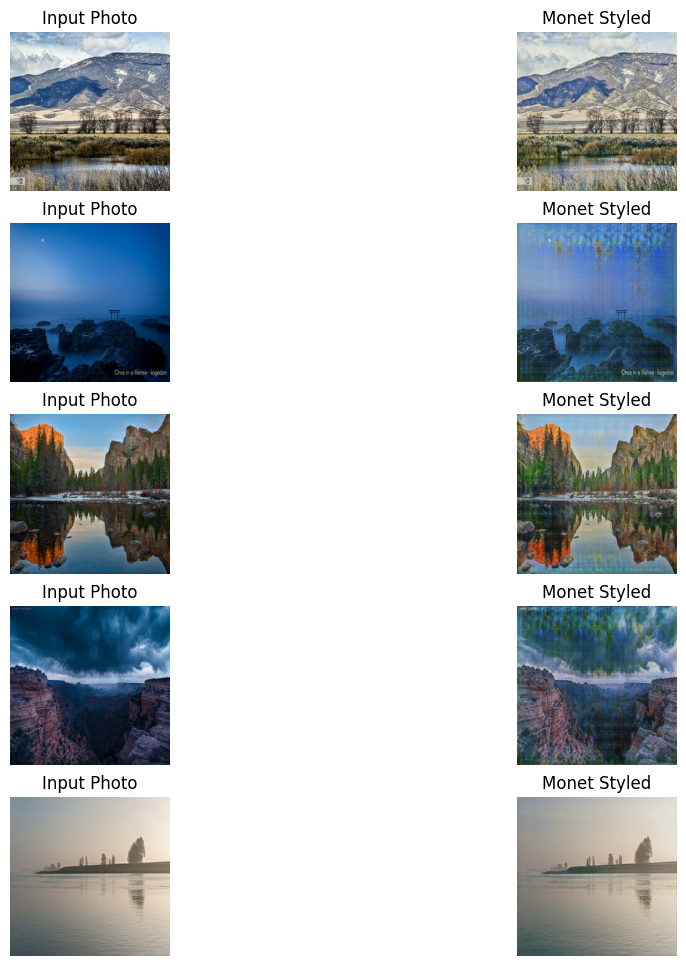

In [22]:
# let's look at some sample images from our "best" model


_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_tf_dataset.take(5)):
    prediction = gen_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet Styled")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [23]:
epoch_loss_df = pd.read_csv('/kaggle/input/epoch-loss/5511_scores.csv',index_col=0)
epoch_loss_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 1 to 25
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   v8-gen_loss_p    25 non-null     float64
 1   v8-gen_loss_m    25 non-null     float64
 2   v8-disc_loss_p   25 non-null     float64
 3   v8-disc_loss_m   25 non-null     float64
 4   v9-gen_loss_p    25 non-null     float64
 5   v9-gen_loss_m    25 non-null     float64
 6   v9-disc_loss_p   25 non-null     float64
 7   v9-disc_loss_m   25 non-null     float64
 8   v11-gen_loss_p   25 non-null     float64
 9   v11-gen_loss_m   25 non-null     float64
 10  v11-disc_loss_p  25 non-null     float64
 11  v11-disc_loss_m  25 non-null     float64
dtypes: float64(12)
memory usage: 2.5 KB


In [24]:
# let's look at our loss scores in each

def make_plot(epoch_loss_df,col,title):
    """
    Helper function to make plots
    """
    plt.plot(epoch_loss_df['v8-'+col],color='darkgreen')
    plt.plot(epoch_loss_df['v9-'+col],color='red')
    plt.plot(epoch_loss_df['v11-'+col],color='blue')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss Score')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

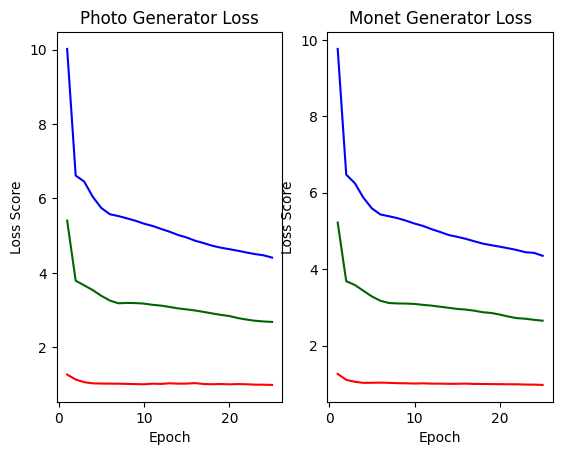

In [25]:
plt.subplot(121)
make_plot(epoch_loss_df,'gen_loss_p','Photo Generator Loss')

plt.subplot(122)
make_plot(epoch_loss_df,'gen_loss_m','Monet Generator Loss')


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

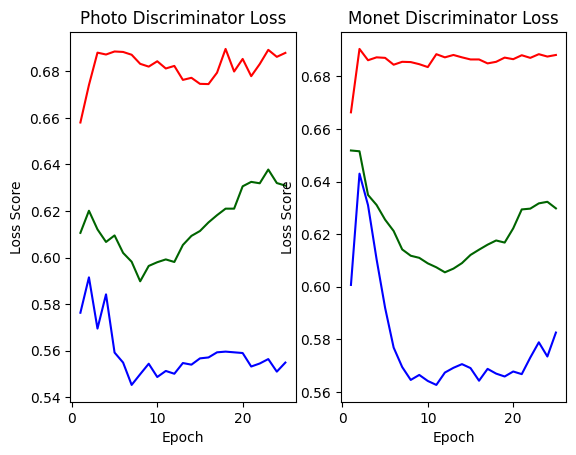

In [26]:

plt.subplot(121)
make_plot(epoch_loss_df,'disc_loss_p','Photo Discriminator Loss')
plt.subplot(122)
make_plot(epoch_loss_df,'disc_loss_m','Monet Discriminator Loss')





## Conclusion (and more Analysis)

Well that took a while. Each 25 epoch model took about 45 minutes and the creation of the prediction results for the kaggle submission took the same time. If I were to do it again, I'd figure out how to get TPU to work in a distributed way to perform the predictions. 

It seems as if 10x generator loss to 1x discriminator loss was the sween spot. It's important to fix ass many variables at a time in order to isolate the effective change. There are a huge number of places one could make model tweak and tune hyper parameters. Changing thee generator or discriminator are ripe with oportunity in addition to the GAN itself where we could change loss functions and learning rates.

Thee largest part I needed to learn / troubleshoot was the use of kaggle UI its self and making sure the runs were on TPU. Becasue we only get 20 hrs of TPU a week, it was important to be efficient with this resource. 


#### Learnings:

1. kaggle TPU is really easy to set up and works fast
2. Tensorflow models can be controlled at all the levels in a "gradual way." Being about to superclass their objects makes it very flexible
3. I don't know much! I know the basics and how to learn and that's good for now. The next task is to find an excuse to do this stuff with a more meaningful project and really focus on how Tensorflow works and what the object underneath are going through. This project was a great introduction!

#### What didn't work:

1. keeping all the data in while iterating. This made things slow
2. using collab - the challenge requires the model be run on their kaggle noteebooks - so that was a time sink
3. trying to decode the gan history. It is a nested array-like object but the shape didn't make when compared to the print out results above. I had to copy and paste it into a csv to make the charts.


#### Ways to Improve:
1. if we had only used a single photo and monet tfrec file while setting everything up, we could havee had things working and then set it all to run and stepped away without fear of breaking
2. getting programatical about adding and removing layers in our generator and discriminator modeels as well as trying various loss function combinations in order to seek out the best GAN
3. 